In [ ]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/rec/"

In [ ]:
d1 = pd.read_json(DATA_DIR + "rand1.json", lines=True)
d2 = pd.read_json(DATA_DIR + "rand2.json", lines=True)
light1 = pd.read_json(DATA_DIR + "light_huge1.json", lines=True)
light2 = pd.read_json(DATA_DIR + "light_huge2.json", lines=True)
sticky = pd.read_json(DATA_DIR + "sticky.json", lines=True)
context1 = pd.read_json(DATA_DIR + "context_1.json", lines=True)
context2 = pd.read_json(DATA_DIR + "context_2.json", lines=True)

In [ ]:
data = pd.concat([d1, d2, light1, light2, sticky, context1, context2], ignore_index=True, sort=False)
print(data.shape)

(2607223, 8)


In [ ]:
data["rnd"] = np.random.random(len(data))

data.head(20)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2023-04-10 20:59:40.045,6055,18427,0.95,0.000909,43578.0,{'AA': 'C'},0.374540
1,next,2023-04-10 20:59:40.072,9690,29879,0.07,0.001138,881.0,{'AA': 'T1'},0.950714
2,next,2023-04-10 20:59:40.076,8544,37582,0.36,0.001054,14550.0,{'AA': 'T1'},0.731994
3,last,2023-04-10 20:59:40.079,8611,15965,0.02,0.000418,NaN,{'AA': 'C'},0.598658
4,next,2023-04-10 20:59:40.082,8350,37800,1.00,0.000906,47333.0,{'AA': 'C'},0.156019
5,last,2023-04-10 20:59:40.087,290,22833,0.00,0.000380,NaN,{'AA': 'C'},0.155995
6,next,2023-04-10 20:59:40.090,3357,8275,1.00,0.000928,46236.0,{'AA': 'T1'},0.058084
7,next,2023-04-10 20:59:40.093,2408,10224,0.01,0.000822,32502.0,{'AA': 'T1'},0.866176
8,next,2023-04-10 20:59:40.096,8390,29204,1.00,0.000953,48137.0,{'AA': 'C'},0.601115
9,next,2023-04-10 20:59:40.101,6055,43578,0.02,0.001240,23232.0,{'AA': 'C'},0.708073


## Compute track popularity

In [ ]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,246,1425.15
1,177,1398.76
2,176,1388.02
3,171,1373.51
4,170,1344.61


In [ ]:
len(track_popularity)

49998

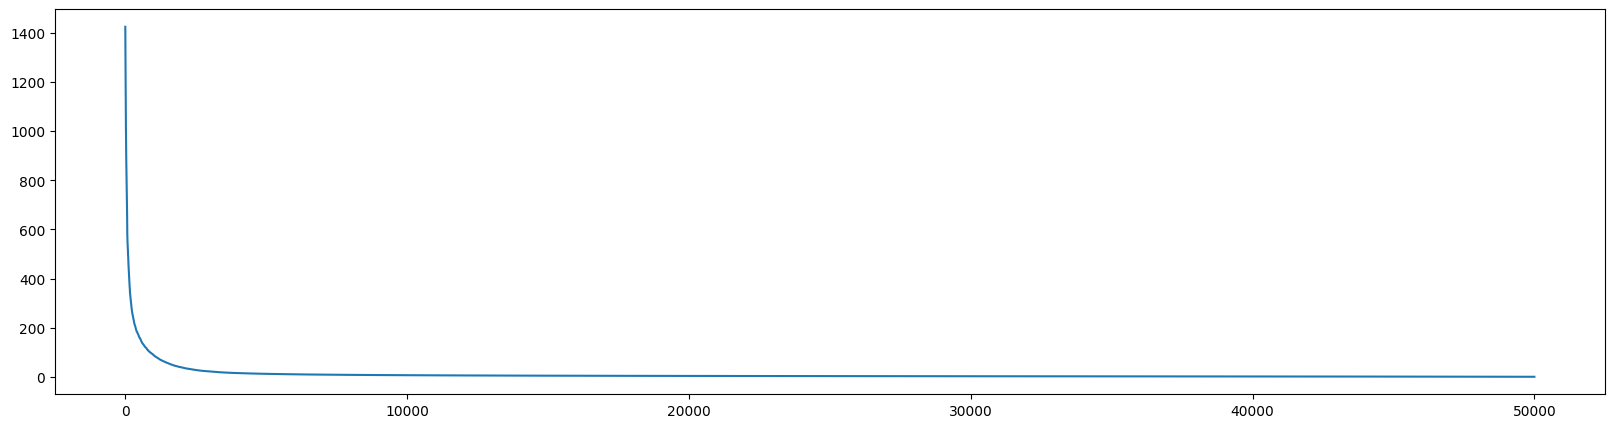

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

# ax.set_xscale("log")
# ax.set_yscale("log")

pass

## Compute offline metrics

In [ ]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [ ]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,415226.000000,415226.000000,415226.000000,415226.000000
mean,0.002971,0.002971,0.001752,0.000519
std,0.016980,0.016980,0.013121,0.007182
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


In [ ]:
def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [ ]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,415226.000000,415226.000000,415226.000000,415226.000000
mean,0.014861,0.008588,0.009440,0.003838
std,0.069653,0.066420,0.054369,0.029071
min,0.000000,0.000000,0.000000,0.000000
25%,0.000205,0.000000,0.000000,0.000000
50%,0.001094,0.000000,0.000000,0.001033
75%,0.005464,0.000000,0.000000,0.002066
max,1.000000,1.000000,1.000000,1.000000


## Export data for prod

In [ ]:
with open(DATA_DIR+"top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)